clean up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import VAE_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Loading the trained VAE

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = utils.load_vae_conv_2('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True) # v21/bis_bis

Instructions for updating:
Colocations handled automatically by placer.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f293177ecc0> and <tensorflow.python.keras.layers.core.Flatten object at 0x7f2931761ac8>).


In [3]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v16/mse/',6, folder= True) #v15/bis # v12/bis2

Instructions for updating:
Colocations handled automatically by placer.


In [65]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v14/mse/',10, folder = True)#v13/bis/ #v9/bis2

# Load data

In [5]:
data_dir = "/sps/lsst/users/barcelin/data/single_galaxies/28/test/"
root = 'galaxies_isolated_20191022_0'

In [6]:
images = np.load(data_dir+'galaxies_isolated_20191022_0_images.npy', mmap_mode = 'c')

In [7]:
test_sample = [data_dir+'galaxies_isolated_20191022_0_images.npy']

In [8]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

# Parameters to fix

In [9]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [10]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

# VAE LSST R band

Test of data processing functions

In [49]:
N = 100
batch_size = 100

ellipticities_r_band, e_beta_r, flux_in_r, flux_out_r= results_processing.VAE_processing(vae_lsst_r_band_conv, 
                                                                                        test_sample[0],
                                                                                        bands_r,
                                                                                        0,
                                                                                        stamp_size, 
                                                                                        N, 
                                                                                        batch_size, 
                                                                                        PSF, 
                                                                                        pix_scale_lsst)

error for galaxy 54


KeyboardInterrupt: 

In [46]:
errors_r = [54,]

In [48]:
e_out_r = np.sqrt(ellipticities_r_band[:,1,0]**2+ellipticities_r_band[:,1,1]**2)
e_in_r = np.sqrt(ellipticities_r_band[:,0,0]**2+ellipticities_r_band[:,0,1]**2)
delta_e_r = e_out_r - e_in_r 

delta_e_beta = e_beta_r[:,1,0]- e_beta_r[:,0,0]

delta_e1_r = ellipticities_r_band[:,1,0]- ellipticities_r_band[:,0,0]
delta_e2_r = ellipticities_r_band[:,1,1]- ellipticities_r_band[:,0,1]

delta_mag_r = -2.5*np.log10(flux_out_r/flux_in_r)

NameError: name 'ellipticities_r_band' is not defined

## Shape plots

In [16]:
df_plot = {}

df_plot['e1_in'] = ellipticities_r_band[:,0,0]
df_plot['e1_out'] = ellipticities_r_band[:,1,0]

df_plot['e2_in'] = ellipticities_r_band[:,0,1]
df_plot['e2_out'] = ellipticities_r_band[:,1,1]

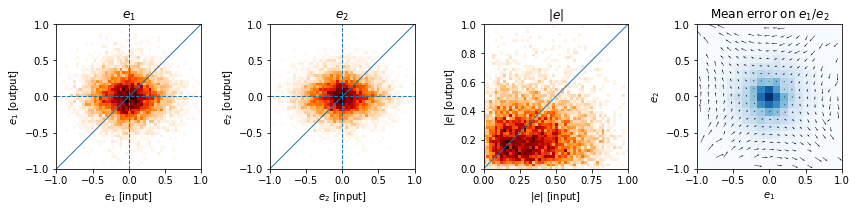

In [17]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')


ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

## LSST all filters

In [66]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [125]:
N = 100
batch_size = 100

ellipticities_lsst, e_beta_lsst, flux_in_lsst, flux_out_lsst = results_processing.VAE_processing(vae_lsst_conv, 
                                                                                          test_sample[0],
                                                                                          bands_lsst,
                                                                                          2,
                                                                                          stamp_size, 
                                                                                          N, 
                                                                                          batch_size,
                                                                                          PSF, 
                                                                                          pix_scale_lsst)

In [126]:
errors_lsst = []

In [127]:
e_in_lsst = np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2)
e_out_lsst = np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2)
delta_e_lsst = e_out_lsst - e_in_lsst

delta_e_lsst_beta = e_beta_lsst[:,1,0]- e_beta_lsst[:,0,0]

delta_e1_lsst = ellipticities_lsst[:,1,0]- ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1]- ellipticities_lsst[:,0,1]

delta_mag_lsst = -2.5*np.log10(flux_out_lsst/flux_in_lsst)

In [128]:
print(ellipticities_lsst.shape)

(40000, 2, 2)


### Shape plots

In [129]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst[:,0,0]
df_plot['e1_out'] = ellipticities_lsst[:,1,0]

df_plot['e2_in'] = ellipticities_lsst[:,0,1]
df_plot['e2_out'] = ellipticities_lsst[:,1,1]

df_plot['e_in'] = np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2)
df_plot['e_out'] = np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2)

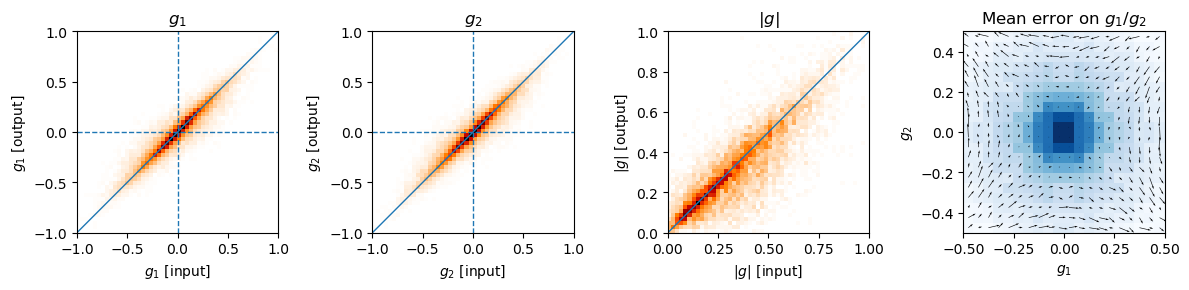

In [130]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,21)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()
#plt.savefig('figures/ellipticities_lsst.pdf', dpi = 300)

## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [134]:
N = 10#, indices_lsst_euclid
batch_size = 100

ellipticities_lsst_euclid, e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid = results_processing.VAE_processing(vae_lsst_euclid_conv, 
                                                                                                                               test_sample[0],
                                                                                                                               bands_lsst_euclid,
                                                                                                                               6,
                                                                                                                               stamp_size, 
                                                                                                                               N, 
                                                                                                                               batch_size,
                                                                                                                               PSF, 
                                                                                                                               pix_scale_lsst)

error for galaxy 14471
error for galaxy 14571
error for galaxy 14671
error for galaxy 14771
error for galaxy 34497
error for galaxy 34597
error for galaxy 34697
error for galaxy 34797


In [135]:
#errors_lsst_euclid = [2714,2751,4544]
errors_lsst_euclid = [7664,7764,7864,7964, 32856,32956,33056,33156 ]

In [136]:
e_in_lsst_euclid = np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2)
e_out_lsst_euclid = np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2)
delta_e_lsst_euclid = e_out_lsst_euclid - e_in_lsst_euclid

delta_e_lsst_euclid_beta= e_beta_lsst_euclid[:,1,0]- e_beta_lsst_euclid[:,0,0]

delta_e1_lsst_euclid = ellipticities_lsst_euclid[:,1,0]- ellipticities_lsst_euclid[:,0,0]
delta_e2_lsst_euclid = ellipticities_lsst_euclid[:,1,1]- ellipticities_lsst_euclid[:,0,1]

delta_mag_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid/flux_in_lsst_euclid)

In [137]:
ellipticities_lsst_euclid[:,0,0].shape

(40000,)

In [138]:
print(ellipticities_lsst_euclid[32,0,:])
print(ellipticities_lsst_euclid[132,0,:])
print(ellipticities_lsst_euclid[232,0,:])
print(ellipticities_lsst_euclid[332,0,:])

[ 0.55278713 -0.02187397]
[0.55278713 0.02187404]
[-0.55278718  0.021874  ]
[-0.55278718 -0.02187401]


### Shape plots

In [139]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst_euclid[:,0,0]
df_plot['e1_out'] = ellipticities_lsst_euclid[:,1,0]

df_plot['e2_in'] = ellipticities_lsst_euclid[:,0,1]
df_plot['e2_out'] = ellipticities_lsst_euclid[:,1,1]

df_plot['e_in'] = np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2)
df_plot['e_in_beta'] = e_beta_lsst_euclid[:,0,0]
df_plot['e_out'] = np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2)
df_plot['e_out_beta'] = e_beta_lsst_euclid[:,1,0]

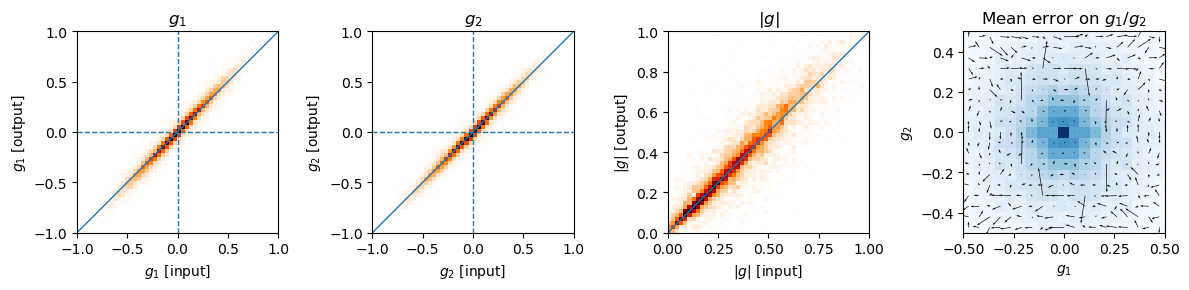

In [140]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

# Delta WL parameters

## As function of SNR

In [61]:
import itertools
from matplotlib.cbook import _reshape_2D
import matplotlib.pyplot as plt
import numpy as np

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

In [62]:
def boxplot(df,x, y, z,
            xlim, ylim, 
            x_scale, 
            legend,
            x_label, y_label,y_label_hist,
            errors = None,
            legend_remove = False,
            palette = ["#3498db","#e74c3c"],
            nbins = 11):
    
    median = []
    q1 = []
    q3 = []
    whislo = []
    whishi = []
    
    matplotlib.rcdefaults()
    
    if errors is not None:
        df_plot = df.drop(errors)
    else:
        df_plot = df
    df_plot = df_plot.dropna()
    
    if x_scale == 'log':
        x_bins = np.geomspace(xlim[0], xlim[1], nbins+1)
    else :
        x_bins = np.linspace(xlim[0], xlim[1], nbins+1)
    
    x_bins[0] -= 1e-5
    x_bins[-1] += 1e-5
    
    idx = np.digitize(df_plot[x], x_bins)    

    fig, axes = plt.subplots(2,1, figsize=(4,3), gridspec_kw={'height_ratios': [1, 3]})
    #fig.subplots_adjust(hspace=0,wspace=0.1) #right=1, left=0,
    #
    #fig.tight_layout()

    fig.subplots_adjust(hspace=0)
    
    if x_scale == 'log':
        sns.distplot(np.log10(df_plot[x]), ax=axes[0], color='0.8')
        axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
    else:
        sns.distplot(df_plot[x], ax=axes[0], color='0.8')
        axes[0].set_xlim(xlim[0], xlim[1])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_ylabel(y_label_hist)

    ax = axes[1]
    #print(df_plot[z])
    exp = np.unique(df_plot[z])
    N_exp = len(exp)
    #print(exp)
    handles = []
    for ik, key in enumerate(exp):
        print(ik, key)
        stats = {}
        for i in range(1,len(x_bins)):
            stats[i] = my_boxplot_stats(df_plot[y][np.logical_and(idx==i,df_plot[z]==key)].values, whis=[100*scipy.stats.norm.cdf(-2),100*scipy.stats.norm.cdf(2)], percents=[100*scipy.stats.norm.cdf(-1),100*scipy.stats.norm.cdf(1)])[0]
            #print(stats[i])
            median.append(stats[i]['med'])
            q1.append(stats[i]['q1'])
            q3.append(stats[i]['q3'])
            whislo.append(stats[i]['whislo'])
            whishi.append(stats[i]['whishi'])
        # Plot boxplots from our computed statistics
        bp = ax.bxp([stats[i] for i in range(1,len(x_bins))],
                    positions=np.arange(len(x_bins)-1)+.5+0.3*(ik-(N_exp-1.)/2.),
                    widths=0.7/len(np.unique(df_plot[z])),
                    showfliers=False,
                    patch_artist=True,
                    boxprops={'facecolor':(*mpl.colors.to_rgba(palette[ik])[:3],0.25), 'edgecolor':palette[ik]})

        handles.append(bp['boxes'][0])

        # Colour the lines in the boxplot blue
        for element in bp.keys():
            if element != 'boxes':
                plt.setp(bp[element], color=palette[ik])

    if not legend_remove:
        ax.legend(handles, legend, frameon=False, loc ='upper right', borderpad = 0.1, fontsize = 8)
    ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
    ax.set_xticks([])
    ax.set_xlim(0,len(x_bins)-1)
    ax.set_ylabel(y_label)
    ax.set_ylim(ylim[0],ylim[1])
    
    ax = ax.twiny()
    # ax2.set_yticks([])
    ax.set_xlim(xlim[0], xlim[1])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.xaxis.tick_bottom()
    ax.set_xlabel(x_label)
    ax.xaxis.set_label_position('bottom')
    
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    return fig , median , q1, q3, whislo, whishi

In [22]:
df_plot = pd.DataFrame()
errors_lsst_new = []
errors_lsst_euclid_new = []

if errors_lsst != []:
    for i in range (len(errors_lsst)):
        errors_lsst_new.append(errors_lsst[i] + 10000)
else:
    errors_lsst_new = errors_lsst
if errors_lsst_euclid != []:
    for i in range (len(errors_lsst_euclid)):
        errors_lsst_euclid_new.append(errors_lsst_euclid[i] + 20000)
else:
    errors_lsst_euclid_new = errors_lsst_euclid
    
errors = errors_r + errors_lsst_new+ errors_lsst_euclid_new


frames = [df,df,df]
df_plot = pd.concat(frames, ignore_index=True)

if errors is not None:
    df_plot = df_plot.drop(errors)
else:
    df_plot = df_plot

df_plot['e1_out'] = np.concatenate((ellipticities_r_band[:,1,0],ellipticities_lsst[:10000,1,0],ellipticities_lsst_euclid[:,1,0]))
df_plot['e2_out'] = np.concatenate((ellipticities_r_band[:,1,1],ellipticities_lsst[:10000,1,1],ellipticities_lsst_euclid[:,1,1]))
df_plot['e1_in'] = np.concatenate((ellipticities_r_band[:,0,0],ellipticities_lsst[:10000,0,0],ellipticities_lsst_euclid[:,0,0]))
df_plot['e2_in'] = np.concatenate((ellipticities_r_band[:,0,1],ellipticities_lsst[:10000,0,1],ellipticities_lsst_euclid[:,0,1]))

df_plot['e_error_psf'] = np.concatenate((delta_e_beta, delta_e_lsst_beta, delta_e_lsst_euclid_beta))
df_plot['e_error'] = np.concatenate((delta_e_r, delta_e_lsst, delta_e_lsst_euclid))
df_plot['mag_error'] = np.concatenate((delta_mag_r, delta_mag_lsst, delta_mag_lsst_euclid))
df_plot['exp'] = [1]*(len(df)-len(errors_r)) + [2]*(len(df)-len(errors_lsst)) + [3]*(len(df)-len(errors_lsst_euclid))

NameError: name 'errors_r' is not defined

In [72]:
### WITHOUT R BAND

df_plot = pd.DataFrame()
errors_lsst_new = []
errors_lsst_euclid_new = []

errors_lsst_new = errors_lsst
if errors_lsst_euclid != []:
    for i in range (len(errors_lsst_euclid)):
        errors_lsst_euclid_new.append(errors_lsst_euclid[i] + 40000)
else:
    errors_lsst_euclid_new = errors_lsst_euclid
    
errors = errors_lsst_new+ errors_lsst_euclid_new


frames = [df,df,df,df,df,df,df,df]#
df_plot = pd.concat(frames, ignore_index=True)
print(df_plot.shape)
#if errors is not None:
#    df_plot = df_plot.drop(errors)
#else:
#    df_plot = df_plot
print(ellipticities_lsst.shape, ellipticities_lsst_euclid.shape)
df_plot['e1_out'] = np.concatenate((ellipticities_lsst[:,1,0],ellipticities_lsst_euclid[:,1,0]))
df_plot['e2_out'] = np.concatenate((ellipticities_lsst[:,1,1],ellipticities_lsst_euclid[:,1,1]))
df_plot['e1_in'] = np.concatenate((ellipticities_lsst[:,0,0],ellipticities_lsst_euclid[:,0,0]))
df_plot['e2_in'] = np.concatenate((ellipticities_lsst[:,0,1],ellipticities_lsst_euclid[:,0,1]))

df_plot['e_error_psf'] = np.concatenate((delta_e_lsst_beta, delta_e_lsst_euclid_beta))
df_plot['e_error'] = np.concatenate((delta_e_lsst, delta_e_lsst_euclid))
df_plot['mag_error'] = np.concatenate((delta_mag_lsst, delta_mag_lsst_euclid))
df_plot['exp'] = [1]*(4*len(df)) + [2]*(4*len(df))

(80000, 7)
(40000, 2, 2) (40000, 2, 2)


In [73]:
np.min(df['SNR_peak'])

4.730731223118252

0 1
1 2


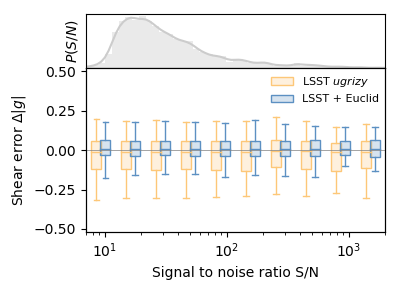

In [74]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.52, 0.52), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.35,0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

0 1
1 2


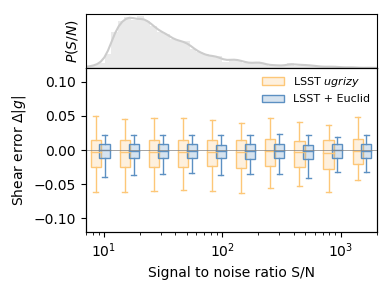

In [75]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error_psf', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.12, 0.12), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.35,0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

0 1
1 2
2 3


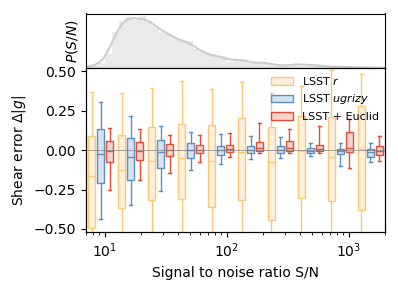

In [92]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.52, 0.52), 
              x_scale = 'log',
              legend = ['LSST $r$', 'LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.35,0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

In [103]:
select = (df_plot['SNR_peak']>500) & (df_plot['e_error']>0.15)
df_plot_chelou = df_plot[select]

In [97]:
df_plot_chelou

,redshift,moment_sigma,e1,e2,SNR,SNR_peak,mag,e1_out,e2_out,e_error_psf,e_error,mag_error,exp
531,0.222400,4.096600,-0.166125,0.072214,22.544670,624.186922,0.591868,-0.394369,0.200023,0.074785,0.261052,3.846535,1
858,0.503500,2.232676,-0.086812,0.199102,23.150185,544.683161,0.960216,0.338752,0.370365,0.238407,0.284715,1.498681,1
937,0.270600,2.833642,-0.067548,0.008345,21.631994,1220.558632,2.192200,-0.369627,0.152955,0.244970,0.331963,4.072312,1
1184,0.389100,2.483907,-0.125799,-0.188152,22.882289,529.252493,0.863503,0.298158,-0.395733,0.274683,0.269149,2.871417,1
1192,0.359110,2.639734,0.013042,-0.056757,22.261906,835.404916,1.446523,0.329583,-0.457029,0.403205,0.505236,2.833315,1
1225,0.312800,2.545510,0.020025,0.154364,23.108139,505.493327,0.776507,0.061386,-0.348241,0.184022,0.197952,2.531186,1
1264,0.100000,2.230387,0.110086,0.155303,23.220667,513.696103,0.891741,-0.491022,-0.009387,0.204604,0.300749,2.027796,1
1537,0.209000,2.221828,-0.073851,0.118008,22.792420,728.797169,1.377742,-0.071277,0.327316,0.032035,0.195775,4.801278,1
1955,0.529100,3.612180,-0.056496,-0.148816,22.893694,510.083457,0.541575,0.291824,-0.115342,0.090122,0.154612,3.744971,1
2030,0.270600,2.833641,-0.058072,0.035496,21.631994,1220.558818,2.195631,-0.237465,0.392621,0.287623,0.390786,4.094550,1


In [55]:
df_plot_chelou.index

Int64Index([  531,   858,   937,  1184,  1192,  1225,  1264,  1537,  1955,
             2030,  2317,  2420,  2515,  2535,  2563,  2958,  3617,  3720,
             4316,  4411,  4611,  5013,  5074,  5099,  5187,  5614,  5662,
             5924,  6082,  6110,  6177,  6185,  6248,  6392,  7001,  7198,
             7282,  7286,  7324,  7362,  7543,  7569,  7708,  7717,  7733,
             7992,  8519,  8559,  8710,  8717,  8733,  9151,  9224,  9241,
             9420,  9423,  9515,  9570,  9610,  9768,  9889,  9976, 21223,
            21433, 21937, 23166, 24022, 27149, 27271],
           dtype='int64')

In [56]:
images.shape

(10000, 2, 10, 64, 64)

In [58]:
input_noisy = images[:,1]
input_noiseless = images[:,0]

In [70]:
images.shape

(10000, 2, 10, 64, 64)

In [82]:
img_out.shape

(69, 64, 64, 10)

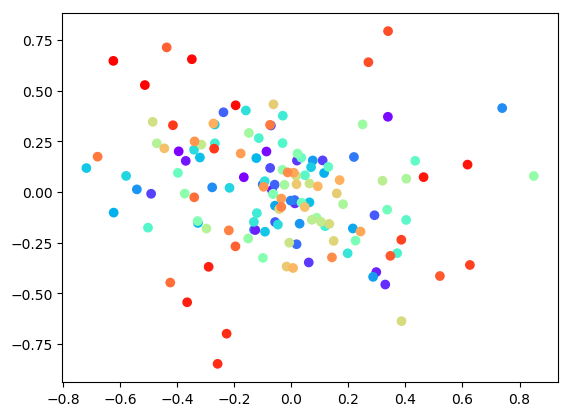

In [110]:
import matplotlib as mpl
plt.scatter(df_plot_chelou['e1_out'], df_plot_chelou['e2_out'], c=np.arange(len(df_plot_chelou['e1_out'])), cmap=mpl.cm.rainbow)
plt.scatter(df_plot_chelou['e1_in'], df_plot_chelou['e2_in'], c=np.arange(len(df_plot_chelou['e1_out'])), cmap=mpl.cm.rainbow)

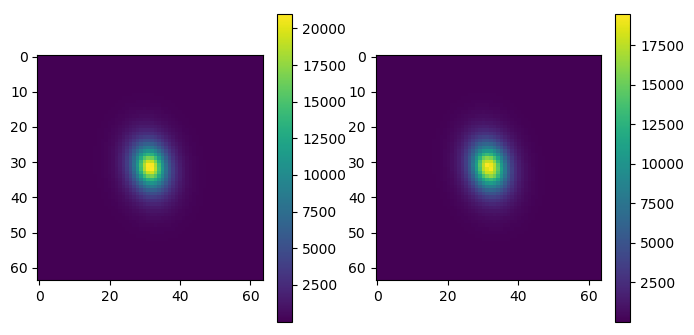

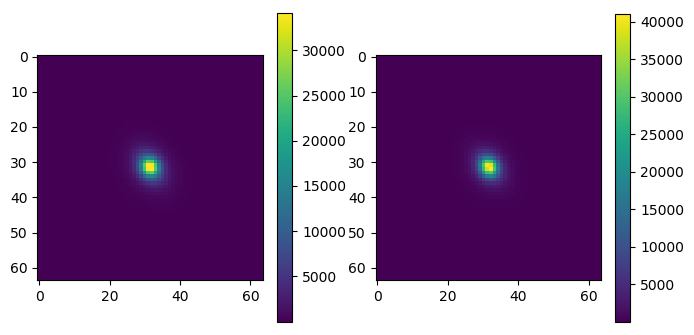

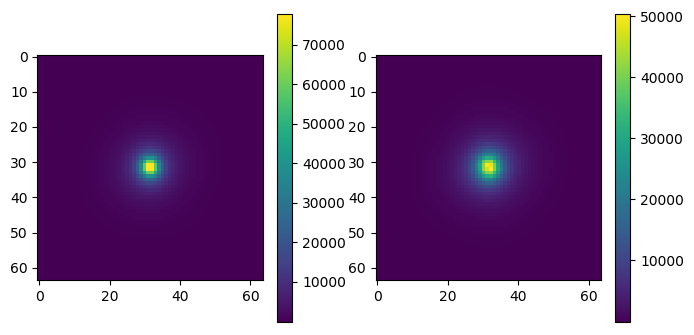

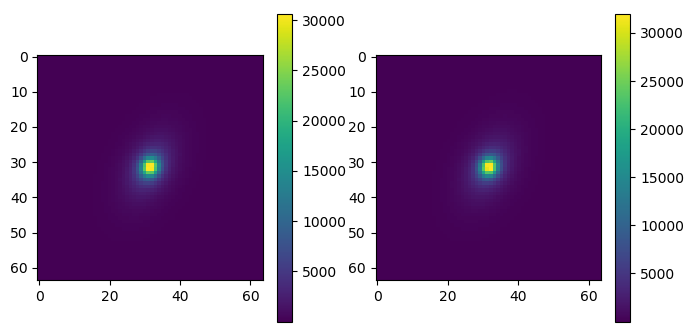

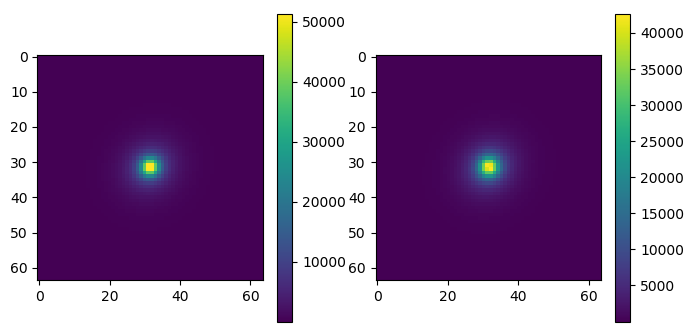

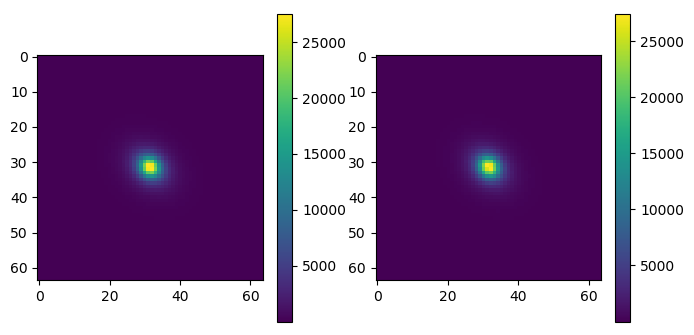

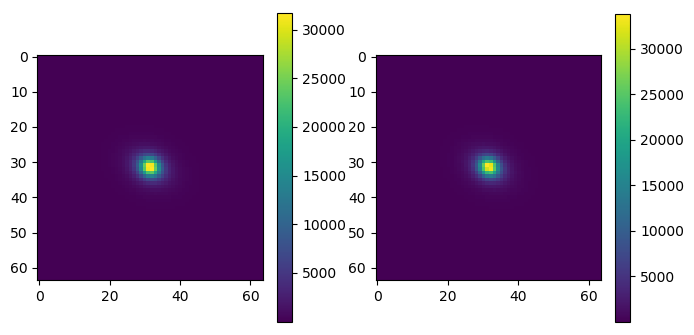

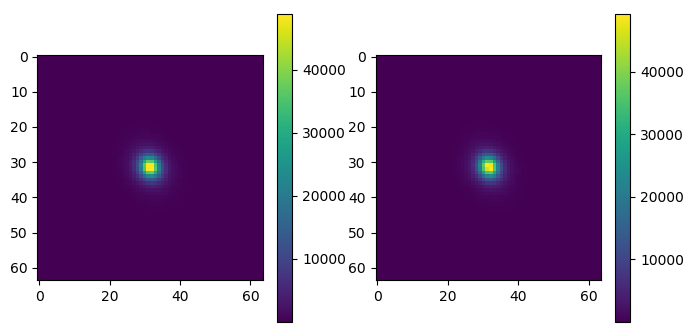

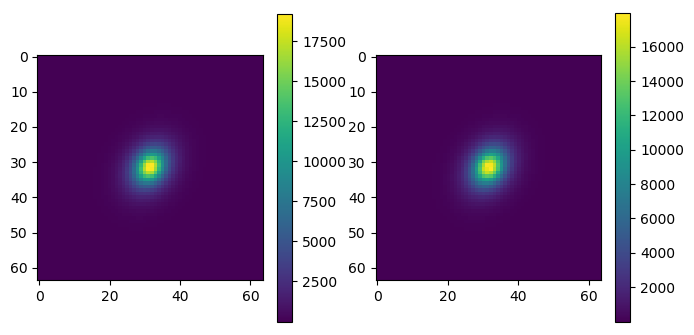

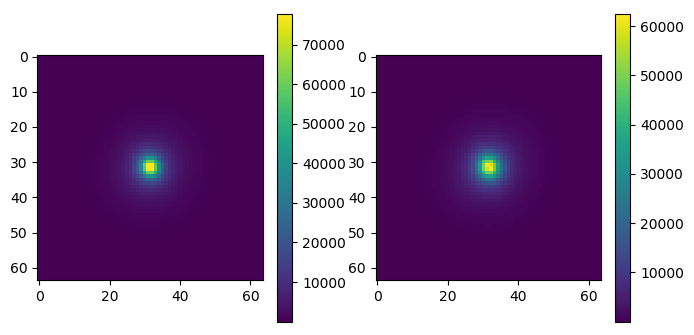

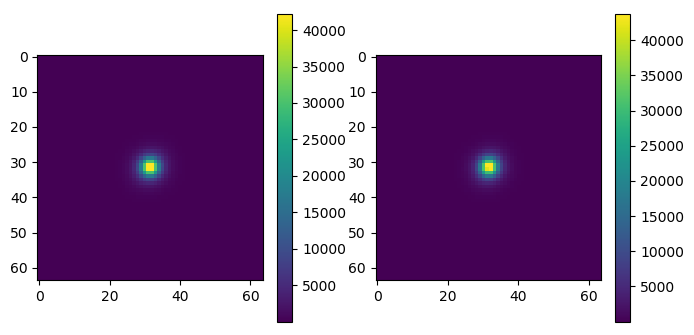

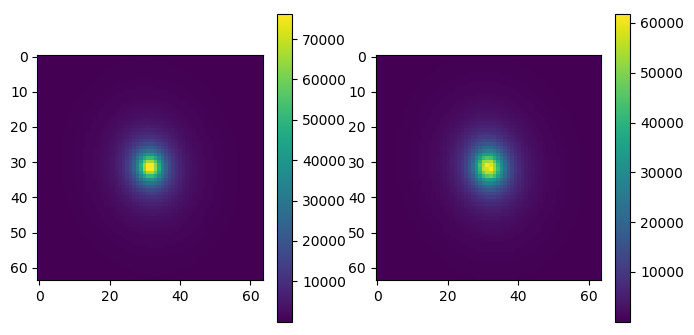

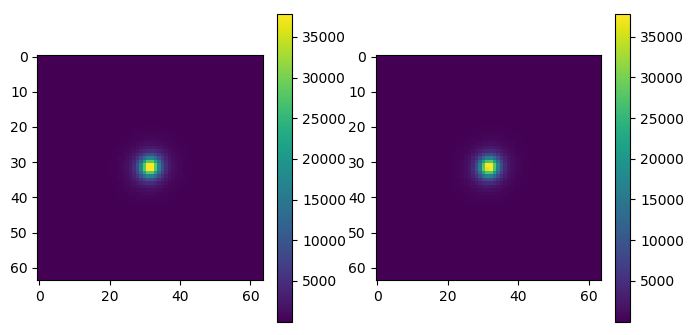

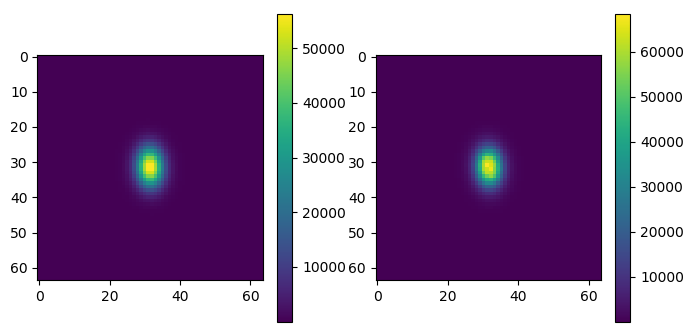

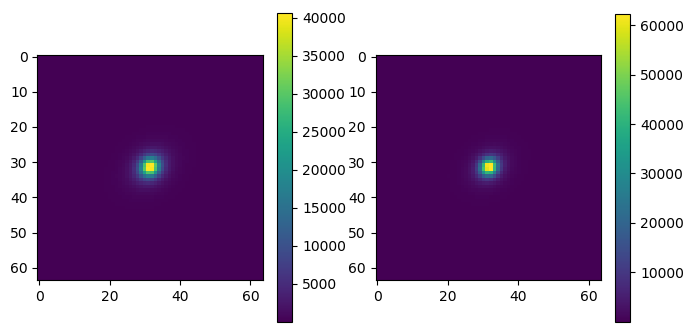

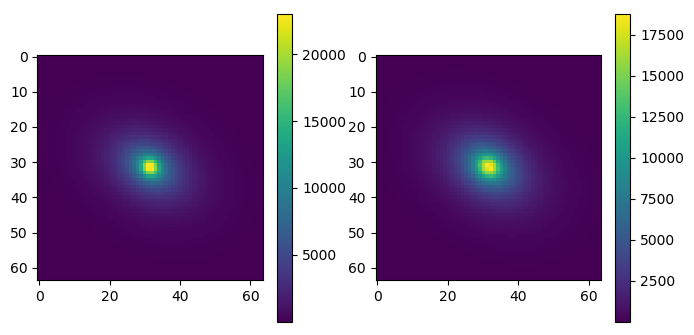

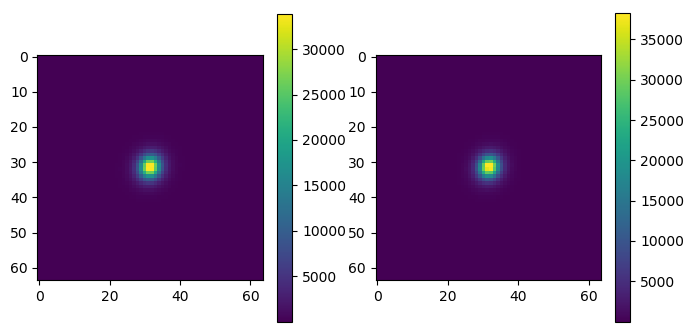

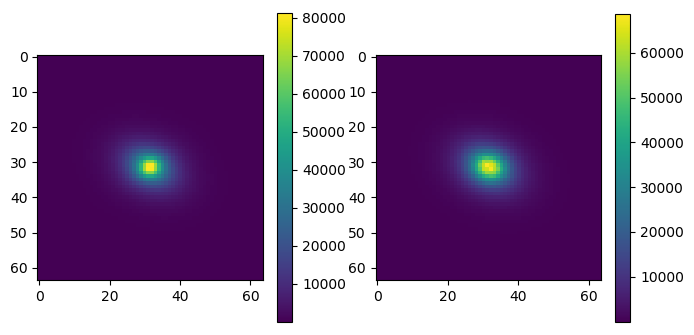

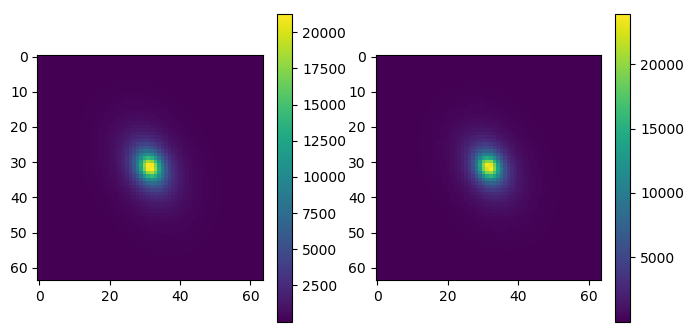

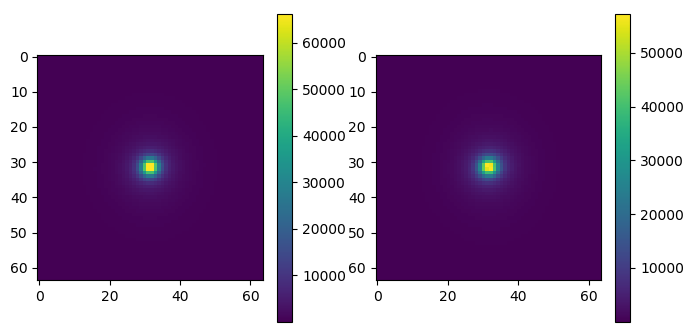

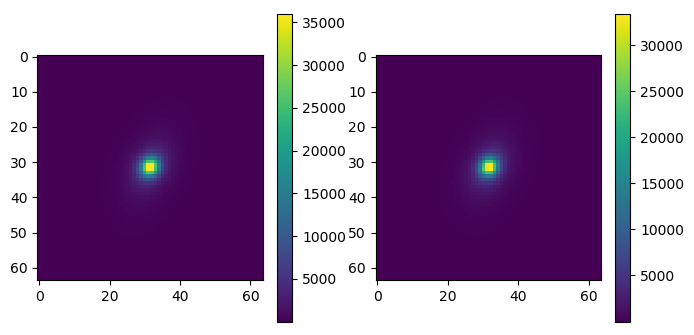

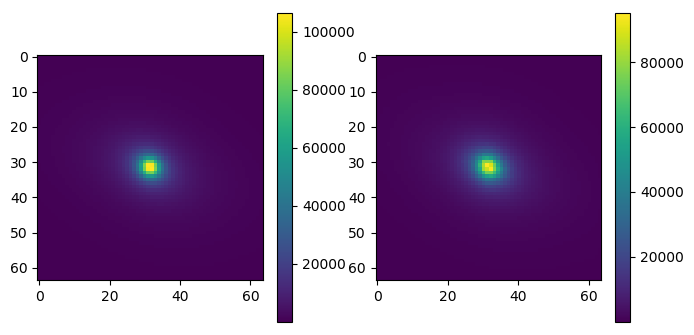

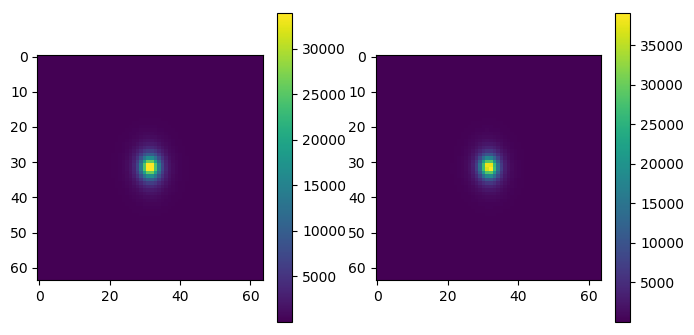

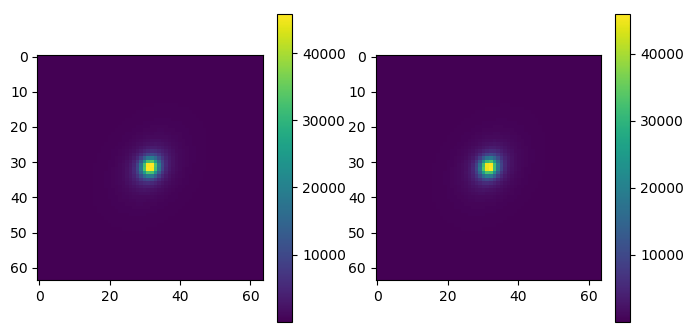

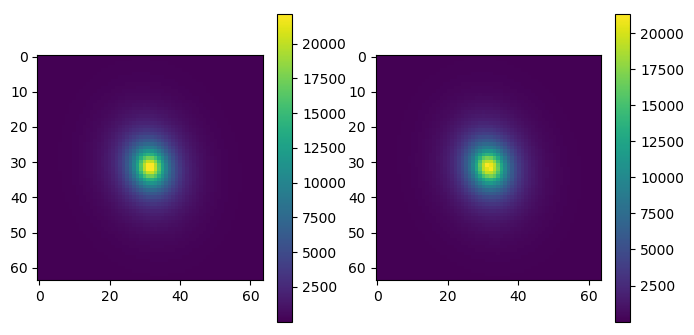

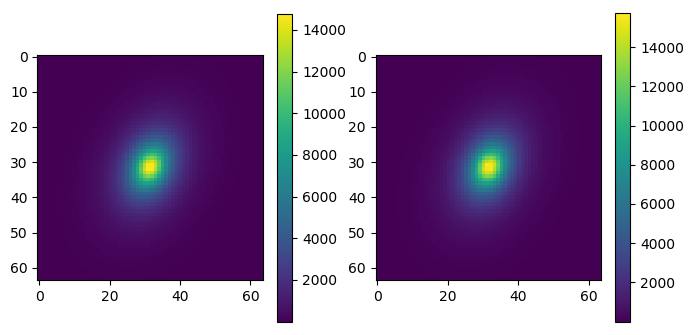

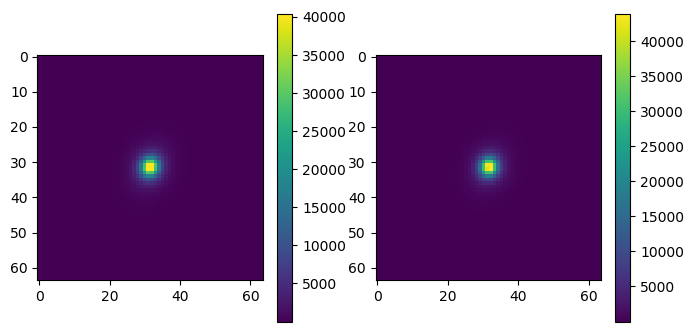

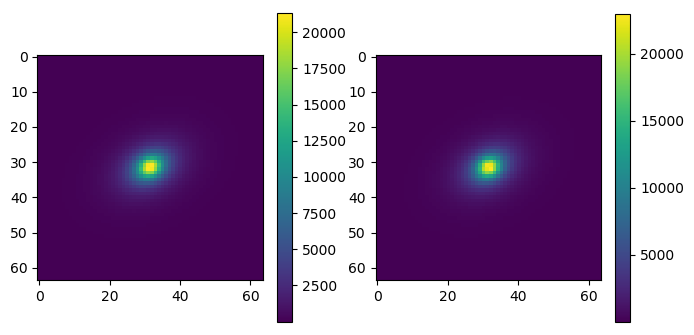

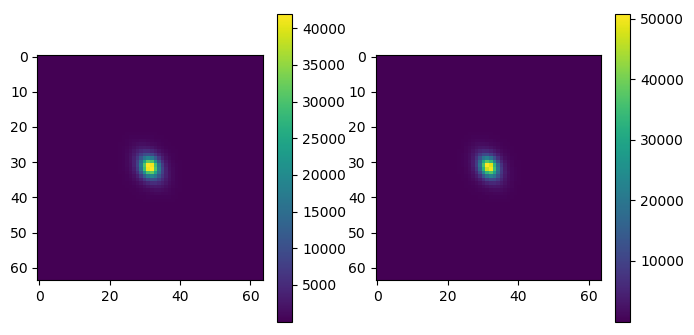

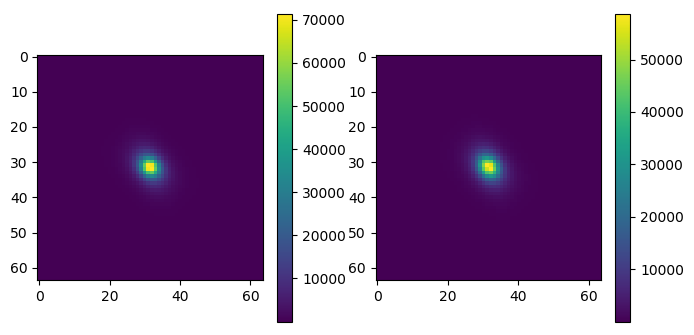

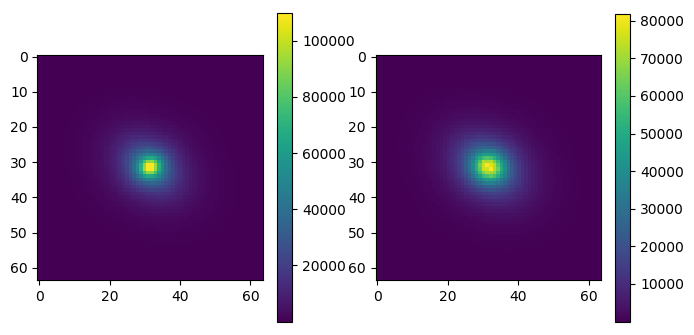

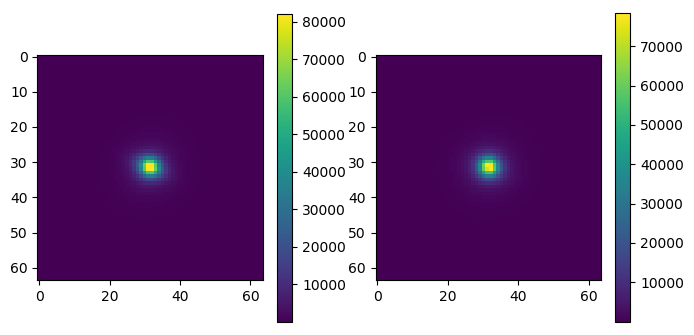

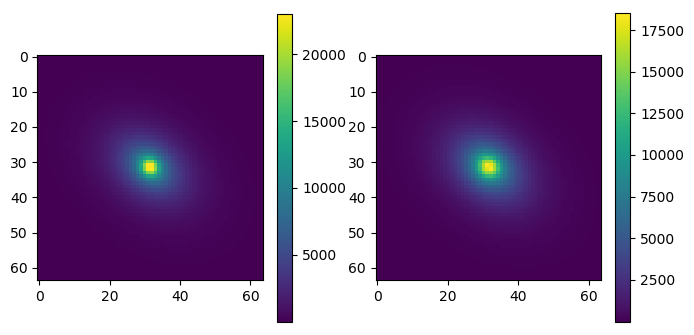

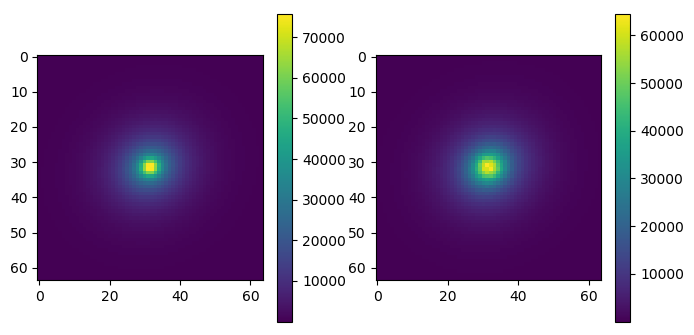

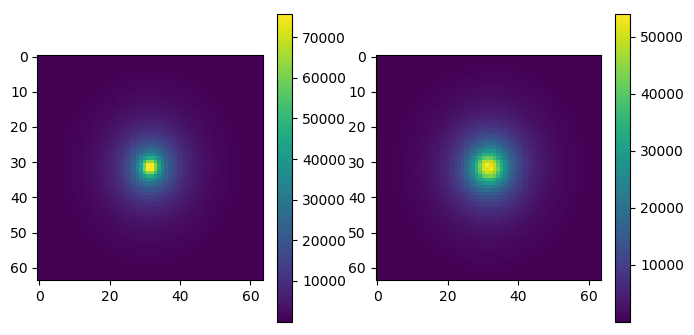

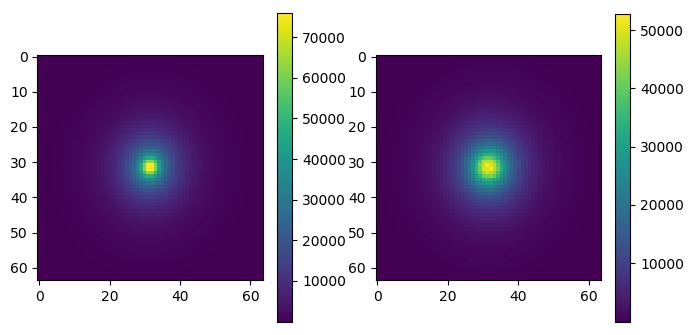

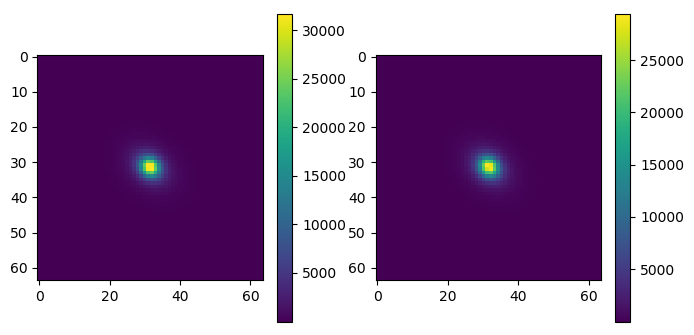

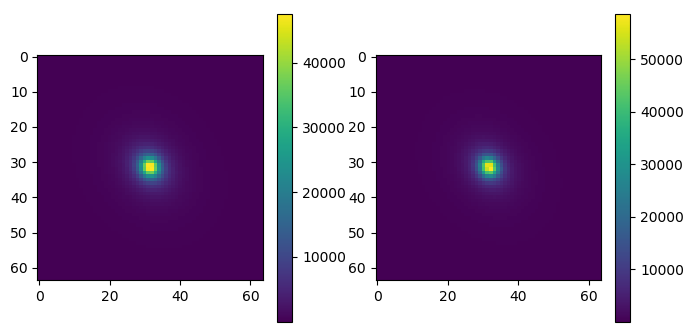

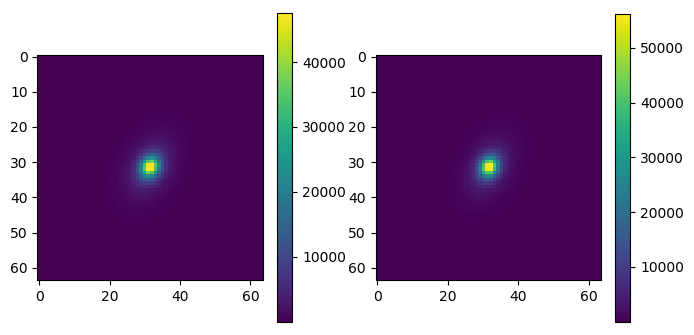

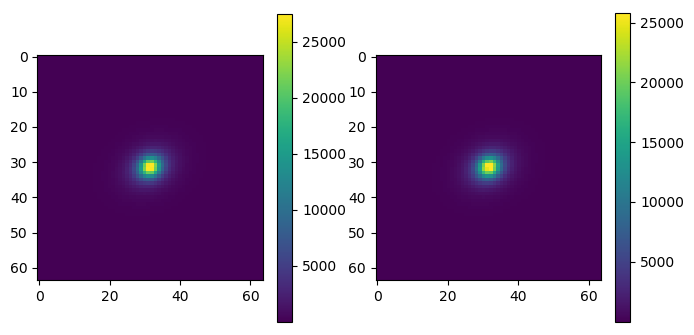

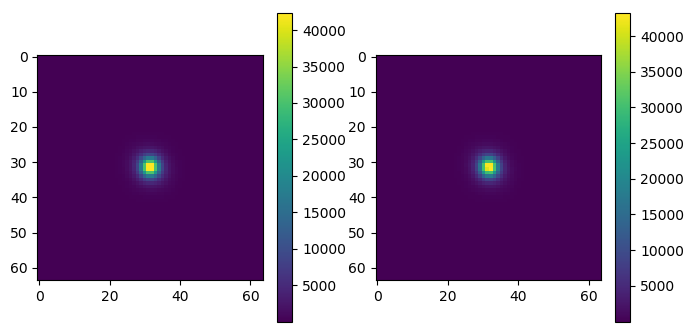

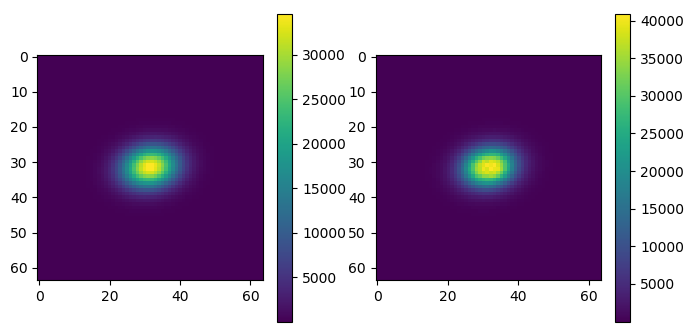

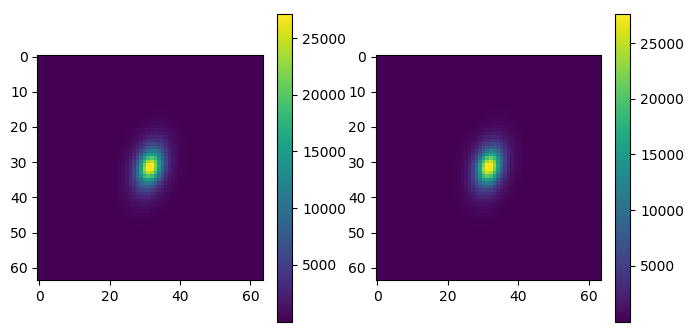

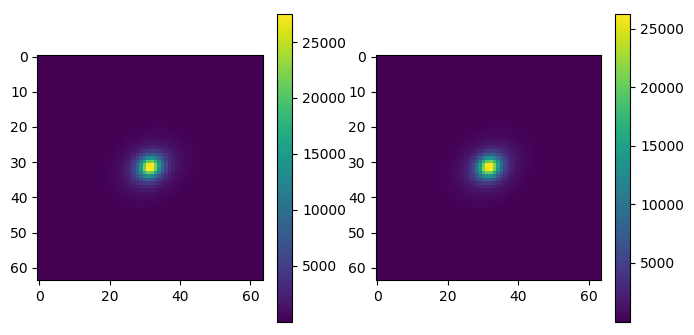

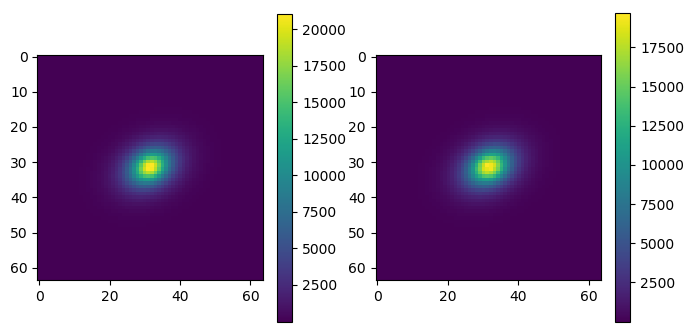

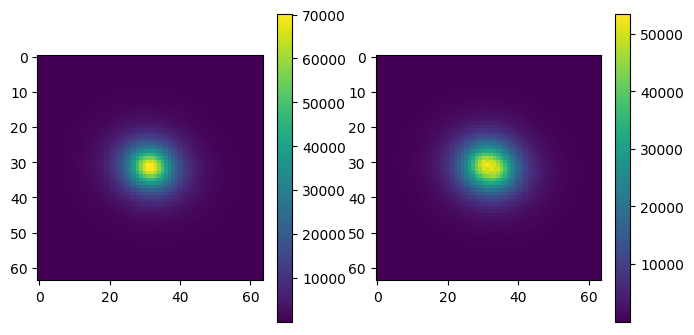

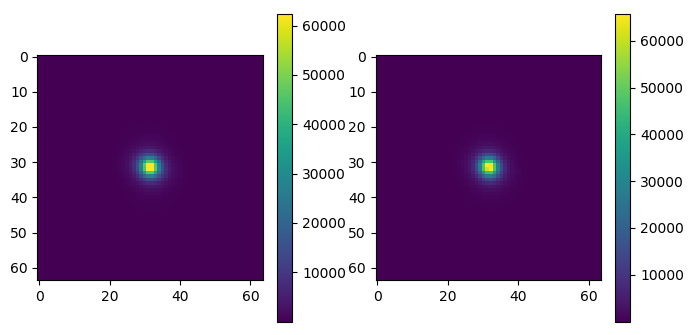

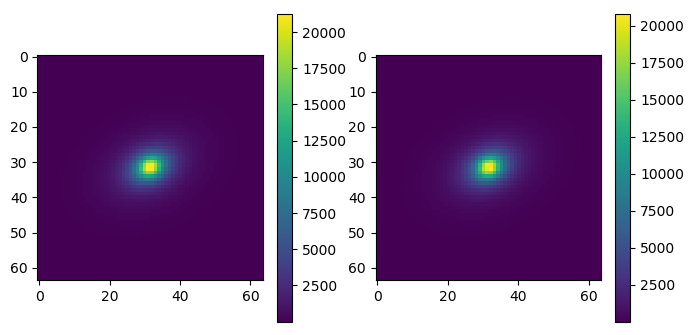

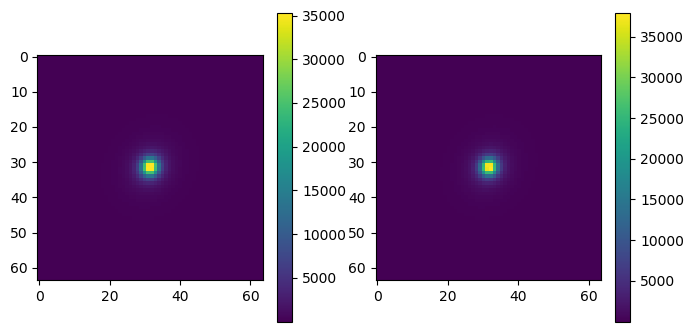

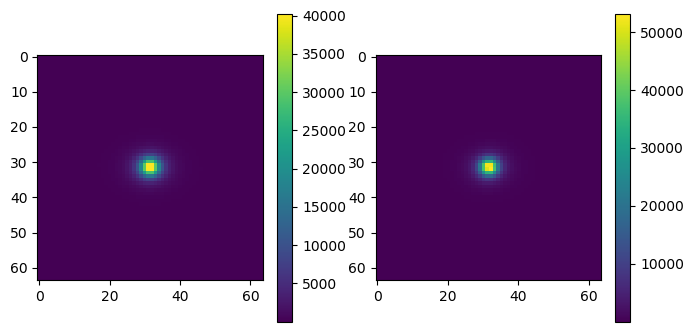

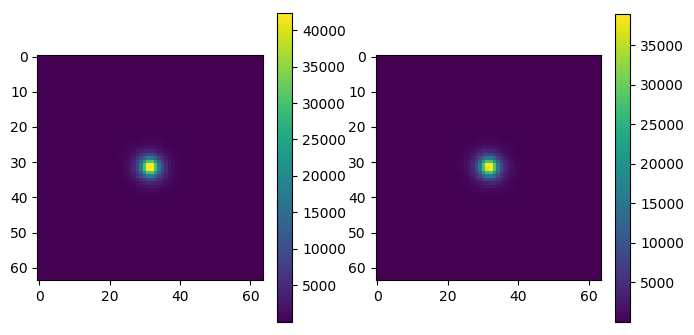

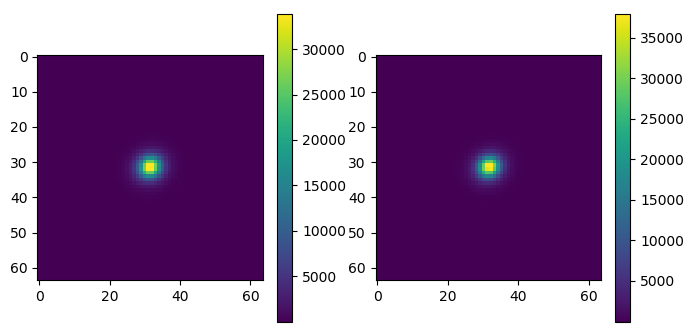

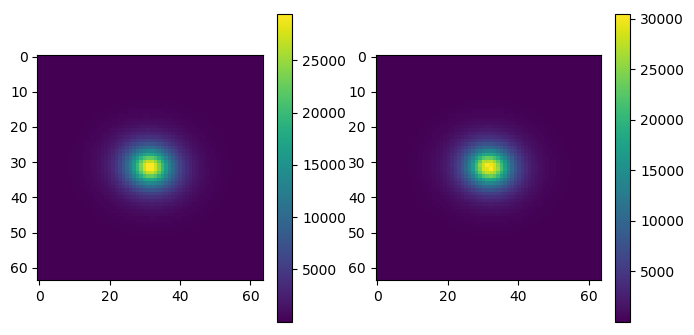

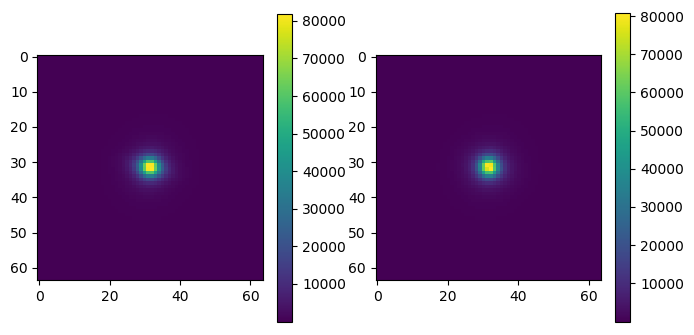

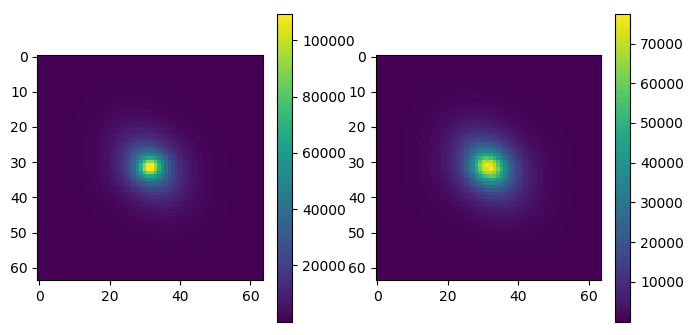

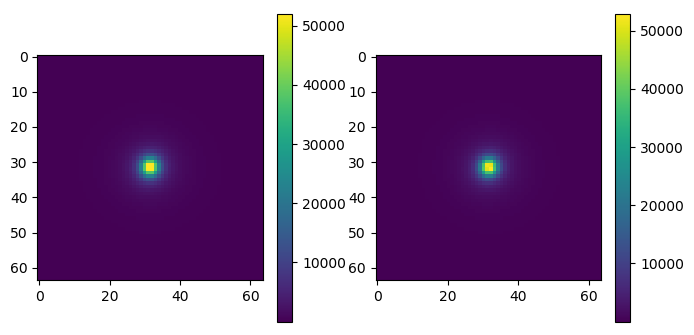

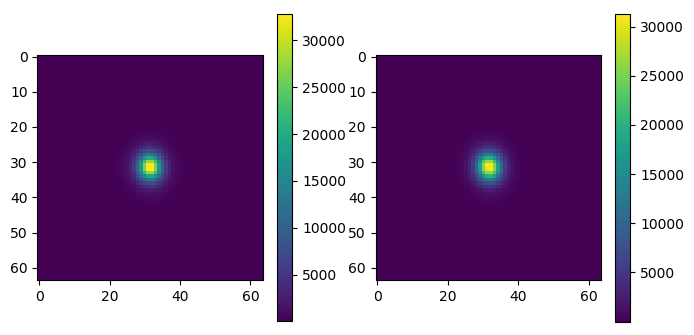

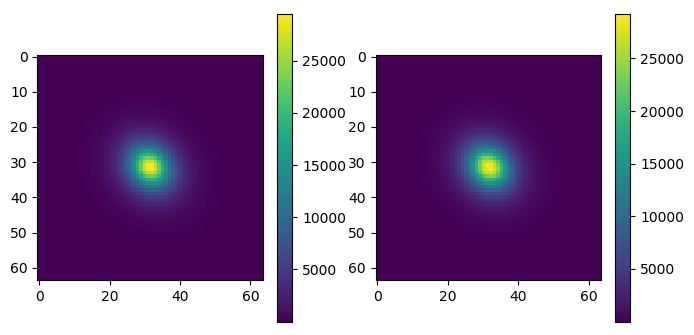

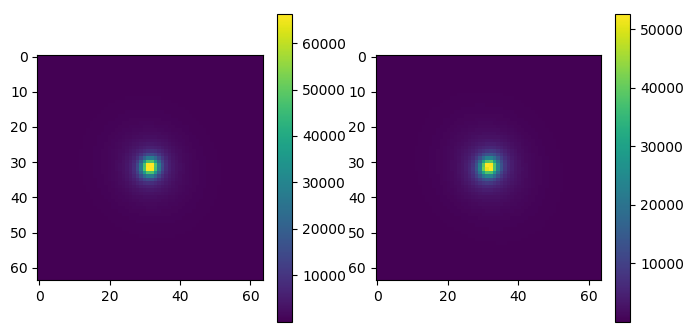

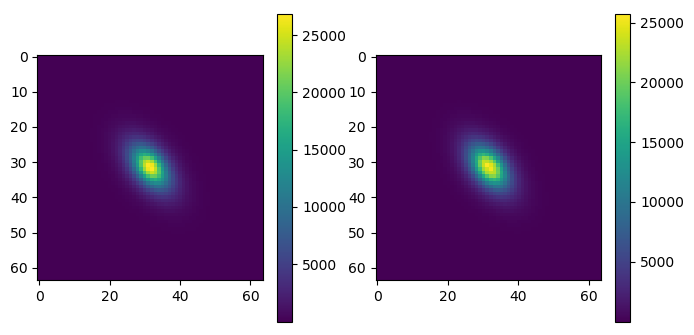

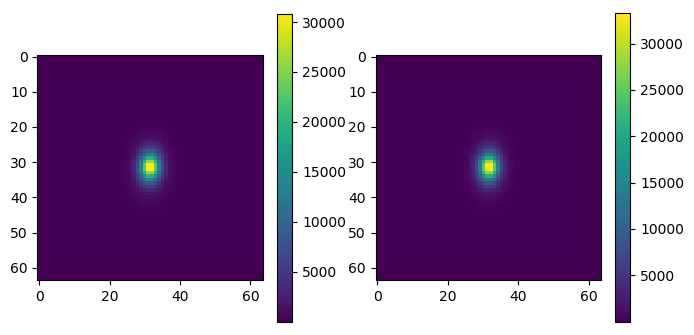

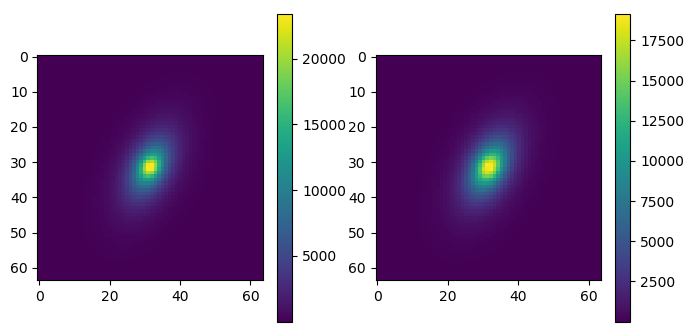

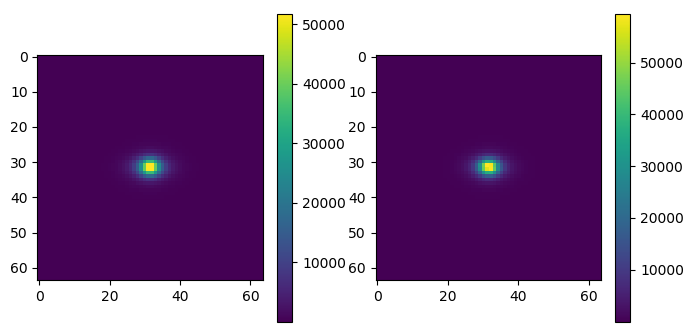

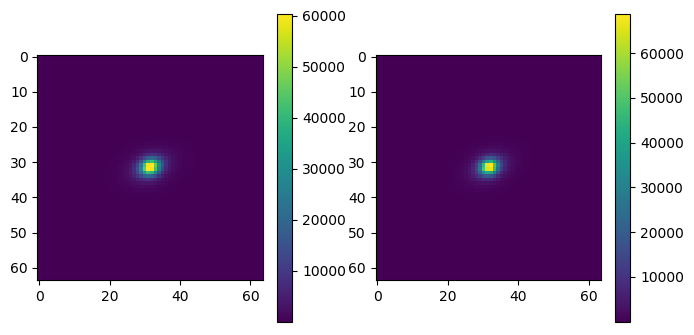

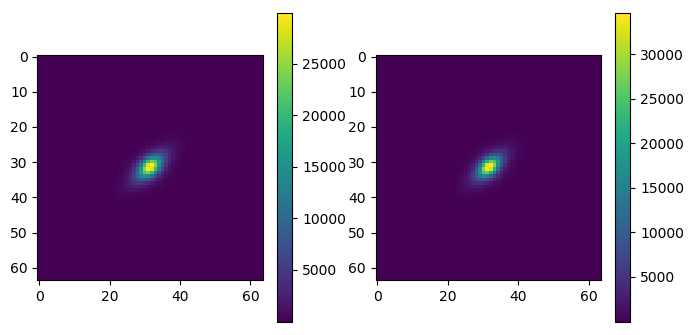

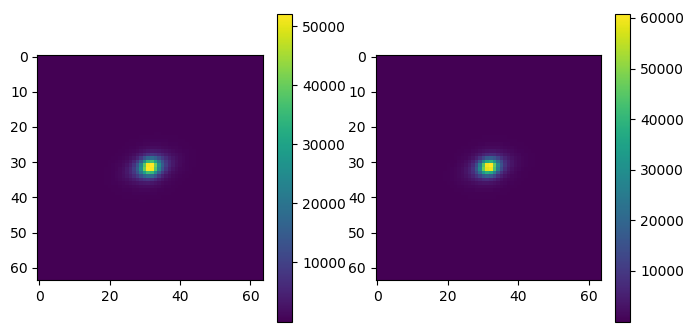

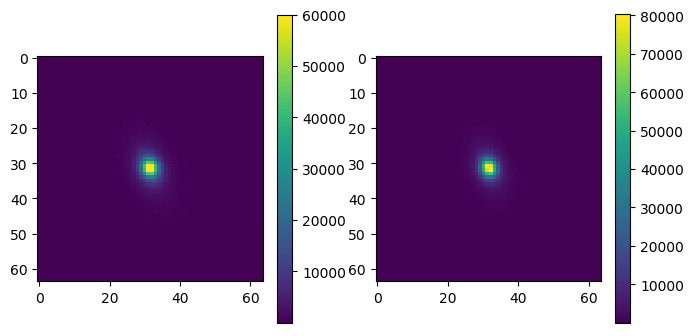

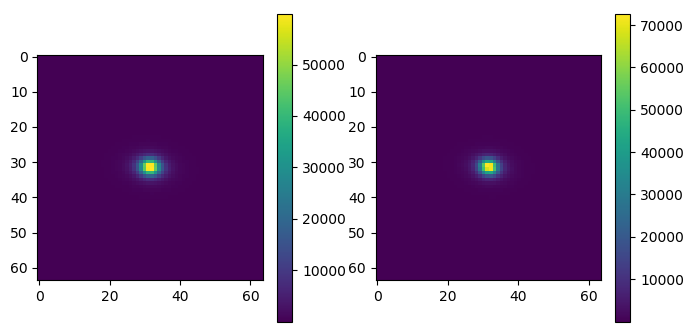

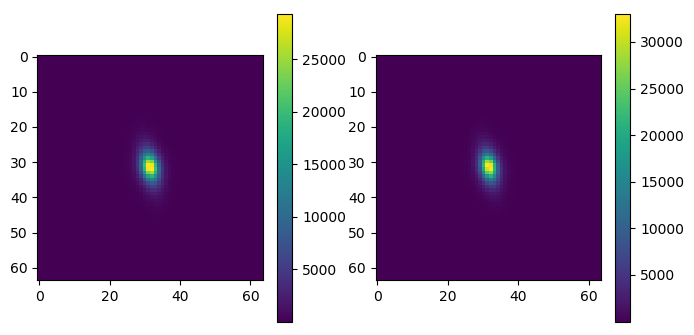

In [85]:
N_plot = 9
#fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
#fig.subplots_adjust(wspace=.01, hspace=.15)

indices = df_plot_chelou.index%10000 #np.random.choice(df_plot_chelou.index, size = 100, )

img_out = utils.denorm(vae_lsst_euclid_conv.predict(utils.norm(images[indices,1],  bands=np.arange(10), inplace=False).transpose([0,2,3,1])), bands=np.arange(10), inplace=False, channel_last=True)
for jj, idx in enumerate(indices):
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    im = axes[0].imshow(images[idx,0,6,:,:])
    plt.colorbar(im, ax=axes[0])
    im = axes[1].imshow(img_out[jj,:,:,6])
    plt.colorbar(im, ax=axes[1])
    plt.show()
        

0 1
1 2
2 3


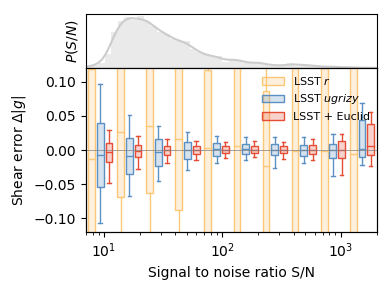

In [37]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error_psf', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.12, 0.12), 
              x_scale = 'log',
              legend = ['LSST $r$', 'LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.35,0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

0 1
1 2
2 3


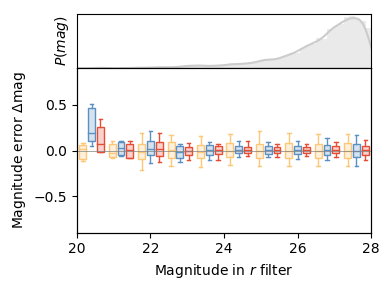

In [52]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot(df_plot, 
              x = 'SNR', y = 'mag_error', z = 'exp',
              xlim = (20, 28),
              ylim = (-0.9, 0.9), 
              x_scale = 'linear',
              legend = ['LSST $r$', 'LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.35,0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

In [53]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = median_shear
df_stat['q1_shear'] = q1_shear
df_stat['q3_shear'] = q3_shear
df_stat['whislo_shear'] = whislo_shear
df_stat['whishi_shear'] = whishi_shear
df_stat['median_mag'] = median_mag
df_stat['q1_mag'] = q1_mag
df_stat['q3_mag'] = q3_mag
df_stat['whislo_mag'] = whislo_mag
df_stat['whishi_mag'] = whishi_mag
df_stat['stats_names'] = ['r band']*10 + ['LSST']*10 + ['LSST Euclid']*10

In [66]:
param = 'median_shear'
x =4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.08148673592081422, -0.021777450019809713, -0.004646400081478825]
improvement between each exp: [3.7417941883319834, 4.686951110090058]


In [67]:
param = 'q1_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.3846431402405489, -0.14339668406398262, -0.04774976269913507]
improvement between each exp: [2.682371232998134, 3.00308684186571]


In [68]:
param = 'q3_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.05605128134437953, 0.08248637884056492, 0.029987731738951855]
improvement between each exp: [0.6795216632399287, 2.750670826277307]


In [69]:
param = 'whislo_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.7232608413441084, -0.29437192715456995, -0.13841826222057566]
improvement between each exp: [2.456962687764502, 2.1266841703696238]


In [70]:
param = 'whishi_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.25273168545003033, 0.20463371751828804, 0.08946267180449145]
improvement between each exp: [1.235044197579237, 2.2873642536128065]


In [59]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.005875948746374172, 0.024837896282496594, 0.011948886416220005]
improvement between each exp: [-0.23657191734531022, 2.0786787502457478]


In [60]:
param = 'q1_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.08181082392928671, -0.03570730136353202, -0.03931890248070341]
improvement between each exp: [2.291151131707768, 0.908145932635229]


In [37]:
param = 'q3_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.07498771778973266, 0.10417360216169129, 0.07158971307643328]
improvement between each exp: [0.7198341636813302, 1.4551476418192875]


In [38]:
param = 'whislo_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.159252965044307, -0.08878044120363, -0.08005287060420248]
improvement between each exp: [1.7937843390419597, 1.1090225813709842]


In [39]:
param = 'whishi_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.1629248613056629, 0.1606000103707291, 0.12570376026940264]
improvement between each exp: [1.0144760322839774, 1.277607050310495]
